In [10]:
import cv2, matplotlib, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# extract bounding recangular from keypoint list
def create_rects(keypoints):
    rects = []
    for kp in keypoints:
        #out_img = cv2.drawKeypoints(out_img, kp, None, flags=2)
        xx1 = min([int(p.pt[0]) for p in kp])
        xx2 = max([int(p.pt[0]) for p in kp])
        yy1 = min([int(p.pt[1]) for p in kp])
        yy2 = max([int(p.pt[1]) for p in kp])
        if xx1 < xx2:
            x1 = xx1
            x2 = xx2
        else:
            x2 = xx1
            x1 = xx2
        if yy1 < yy2:
            y1 = yy1
            y2 = yy2
        else:
            y2 = yy1
            y1 = yy2
        rects.append((x1, y1, x2, y2))
    return rects

# detect to intersect 2 recangulars
def intersect(r1, r2, margin_threshold=15):
    mx1 = max(r1[0], r2[0])
    mx2 = min(r1[2], r2[2])
    my1 = max(r1[1], r2[1])
    my2 = min(r1[3], r2[3])
    result = mx2 - mx1 + margin_threshold > 0 and my2 - my1 + margin_threshold > 0
    connected_rect = (min(r1[0], r2[0]), min(r1[1], r2[1]), max(r1[2], r2[2]), max(r1[3], r2[3]))
    return (result, connected_rect)

def is_valid_rect(rect):
    w, h = (rect[2] - rect[0], rect[3] - rect[1])
    return w >= 10 and h >= 10 and w * h >= 144

def in_boxes(kp, rects, mt=8):
    result = True
    for box in rects:
        in_box = kp.pt[0] > box[0] - mt  and kp.pt[0] < box[2] + mt and kp.pt[1] > box[1] - mt and kp.pt[1] < box[3] + mt
        result = result and (not in_box)
    return result

def marge_rects(input_rects, margin_threshold=15):
    rects = [(r[0], r[1], r[2], r[3]) for r in input_rects]
    connected_pairs1 = [[] for i in range(len(rects))]
    for i in range(len(rects)):
        r1 = rects[i]
        for j in range(i + 1, len(rects)):
            r2 = rects[j]
            result, connected = intersect(r1, r2, margin_threshold)
            if result:
                connected_pairs1[i].append(j)
                rects[i] = connected
                r1 = connected
                rects[j] = connected
    return [rects[i] for i in range(len(connected_pairs1)) if len(connected_pairs1[i]) == 0]

dr = 5
shifts = [(sx, sy) for sx in range(-dr, dr+1) for sy in range(-dr, dr+1)]
def pixel_match(img1, img2, r1, r2):
    x1, y1, x2, y2 = (r1[0], r1[1], r2[0], r2[1])
    w1, h1 = (r1[2] - r1[0], r1[3] - r1[1])
    w2, h2 = (r2[2] - r2[0], r2[3] - r2[1])
    if not abs(w1 - w2) <= dr or not abs(h1 - h2) <= dr:
        return False
    w, h = (min(w1, w2), min(h1, h2))
    for dx, dy in shifts:
        imgr1 = img1[y1:y1+h, x1:x1+w]
        imgr2 = img2[y2+dy:y2+dy+h, x2+dx:x2+dx+w]
        result = np.allclose(imgr1, imgr2)
        if result:
            return True
    return False

def match_kps(kp1, des1, kp2, des2):
    bf = cv2.BFMatcher(2)
    matches = bf.knnMatch(des1, des2, k=3)
    ratio = 0.5
    good = []
    for m, n, p in matches:
        if m.distance < ratio * n.distance:
            good.append([m])
    return good

def cluster_matches(kp1, des1, kp2, des2, matches):
    vectors = []
    num_k = min(int(len(matches) / 3), 15)
    dxw, dyw, wy=(100, 1000, 10.0)
    for m in matches:
        x1, y1 = kp1[m.queryIdx].pt
        x2, y2 = kp2[m.trainIdx].pt
        vectors.append([x1, x2, wy*y1, wy*y2, dxw * (x1 - x2), dyw*(y1-y2)])
    npmat=np.array(vectors)
    criteria =(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, label, center = cv2.kmeans(np.float32(npmat), num_k, None, criteria, 10, cv2.KMEANS_PP_CENTERS)
    cgg = [[] for i in range(num_k)]
    i = 0
    for l in label:
        cgg[l[0]].append(matches[i])
        i = i + 1
    return cgg, ret, label, center

def cluster_kps(kplist, wy = 10.0):
    matt = []
    for kp in kplist:
        matt.append([kp.pt[0], kp.pt[1] * wy])
    num_k = min(int(len(kplist) / 3), 15)
    npmat=np.array(matt)
    criteria =(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, label, center = cv2.kmeans(np.float32(npmat), num_k, None, criteria, 10, cv2.KMEANS_PP_CENTERS)
    kps = [[] for i in range(num_k)]
    i = 0
    for l in label:
        kps[l[0]].append(kplist[i])
        i += 1
    return kps

def render_rects(in_img, rects, color, w=1, padding=8):
    out_img = in_img
    for rect in rects:
        x1, y1, x2, y2 = rect
        out_img = cv2.rectangle(out_img, (x1 - padding, y1 - padding), (x2 + padding, y2 + padding), color, w)
    return out_img

%matplotlib inline

use_canny = True

def detect_diff(suffix):
    img1=cv2.imread('img/actual/' + suffix)
    img2=cv2.imread('img/expected/' + suffix)
    
    # Pre-processes for features detection
    if use_canny:
        img_in1 = cv2.Canny(img1, 10, 40)
        img_in2 = cv2.Canny(img2, 10, 40)
    else:
        img_in1 = img1
        img_in2 = img2
    
    # Detects Keypoints and Feature Descriptors
    akaze = cv2.AKAZE_create()
    kp1, des1 = akaze.detectAndCompute(img_in1, None)
    kp2, des2 = akaze.detectAndCompute(img_in2, None)
    
    # Mathches Features between img1 and img2
    matches = match_kps(kp1, des1, kp2, des2)
    
    # Filters matched pairs and clusters them
    filtered_matches = [m[0] for m in matches if abs(kp1[m[0].queryIdx].pt[0] - kp2[m[0].trainIdx].pt[0]) < 400]
    categorized_matches, ret, label, cetner = cluster_matches(kp1, des1, kp2, des2, filtered_matches)
    
    # Creates list of keypoints whitch is linked from the categorized matched pairs, or not
    categorized_kp1 = [[kp1[m.queryIdx] for m in matches] for matches in categorized_matches]
    categorized_kp2 = [[kp2[m.trainIdx] for m in matches] for matches in categorized_matches]
    not_categorized_kp1 = [kp for kp in kp1 if not kp in [kp1[m.queryIdx] for m in filtered_matches]]
    not_categorized_kp2 = [kp for kp in kp2 if not kp in [kp2[m.trainIdx] for m in filtered_matches]]
    
    # Extracts bounding rectangular for each matching keypoints
    matched_rects1 = create_rects(categorized_kp1)
    matched_rects2 = create_rects(categorized_kp2)
    
    # Tests images cropped by each boundary are same pixel-perfectly.
    # And picks up only "Not matching" rects.
    diff_rects = [(r1, r2) for r1, r2 in [(matched_rects1[i], matched_rects2[i]) for i in range(len(matched_rects1))] if not pixel_match(img1, img2, r1, r2)]
    marged_diff_rects1 = marge_rects([p[0] for p in diff_rects])
    marged_diff_rects2 = marge_rects([p[1] for p in diff_rects])
    
    # Clusters keypoints which are not in matching pairs. They are candidates of "Added(or Removed)" parts.
    # And extracts bounding rectangular for them.
    not_matched_rects1 = create_rects(cluster_kps([kp for kp in not_categorized_kp1 if in_boxes(kp, matched_rects1)]))
    straying_rects1 = marge_rects([r for r in not_matched_rects1 if is_valid_rect(r)])
    not_matched_rects2 = create_rects(cluster_kps([kp for kp in not_categorized_kp2 if in_boxes(kp, matched_rects2)]))
    straying_rects2 = marge_rects([r for r in not_matched_rects2 if is_valid_rect(r)])
    
    # Display images
    out_img1 = img1.copy()
    out_img2 = img2.copy()
    mathching_img = cv2.drawMatchesKnn(img_in1, kp1, img_in2, kp2, [[m] for m in filtered_matches], None, flags=0)
    plt.figure(figsize=(24, 18))
    plt.imshow(mathching_img)
    out_img1 = render_rects(out_img1, marged_diff_rects1, (255, 100, 100), 2)
    # out_img1 = render_rects(out_img1, not_matched_rects1, (200, 200, 255), 2)
    out_img1 = render_rects(out_img1, straying_rects1, (100, 100, 200), 1)
    out_img2 = render_rects(out_img2, marged_diff_rects2, (255, 100, 100), 2)
    # out_img2 = render_rects(out_img2, not_matched_rects2, (200, 200, 255), 2)
    out_img2 = render_rects(out_img2, straying_rects2, (100, 100, 200), 1)
    plt.figure(figsize=(24, 18))
    plt.imshow(out_img1)
    plt.figure(figsize=(24, 18))
    plt.imshow(out_img2)


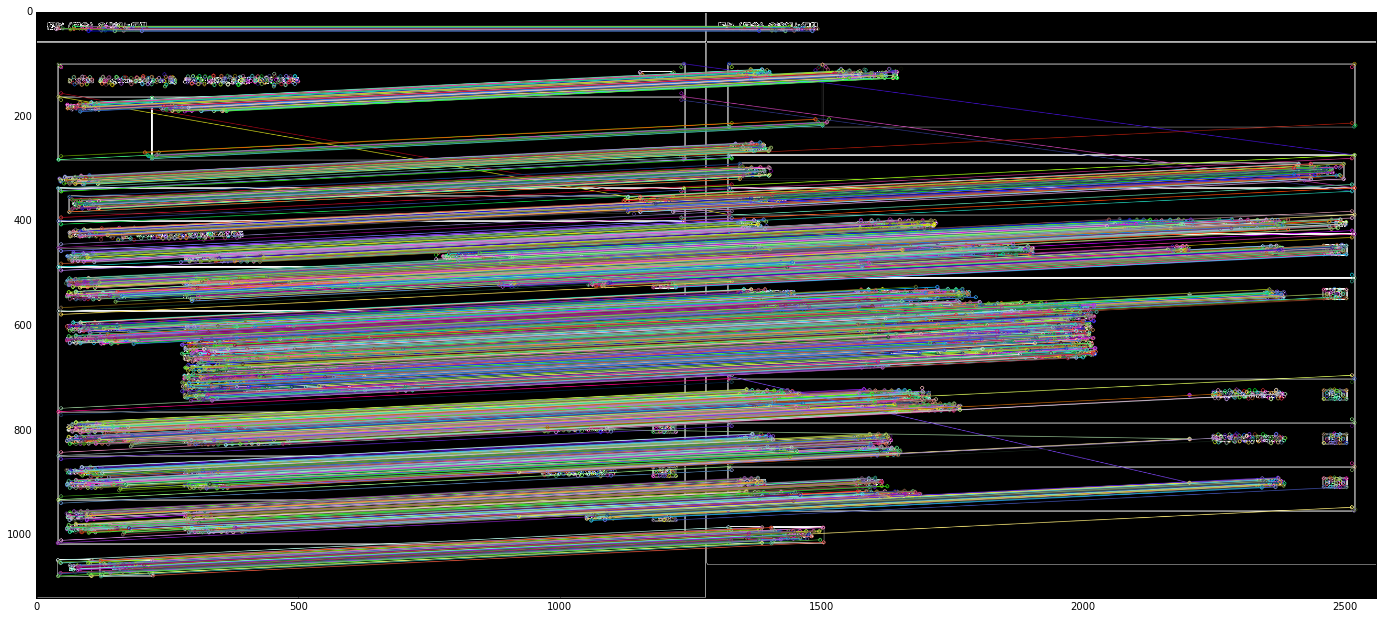

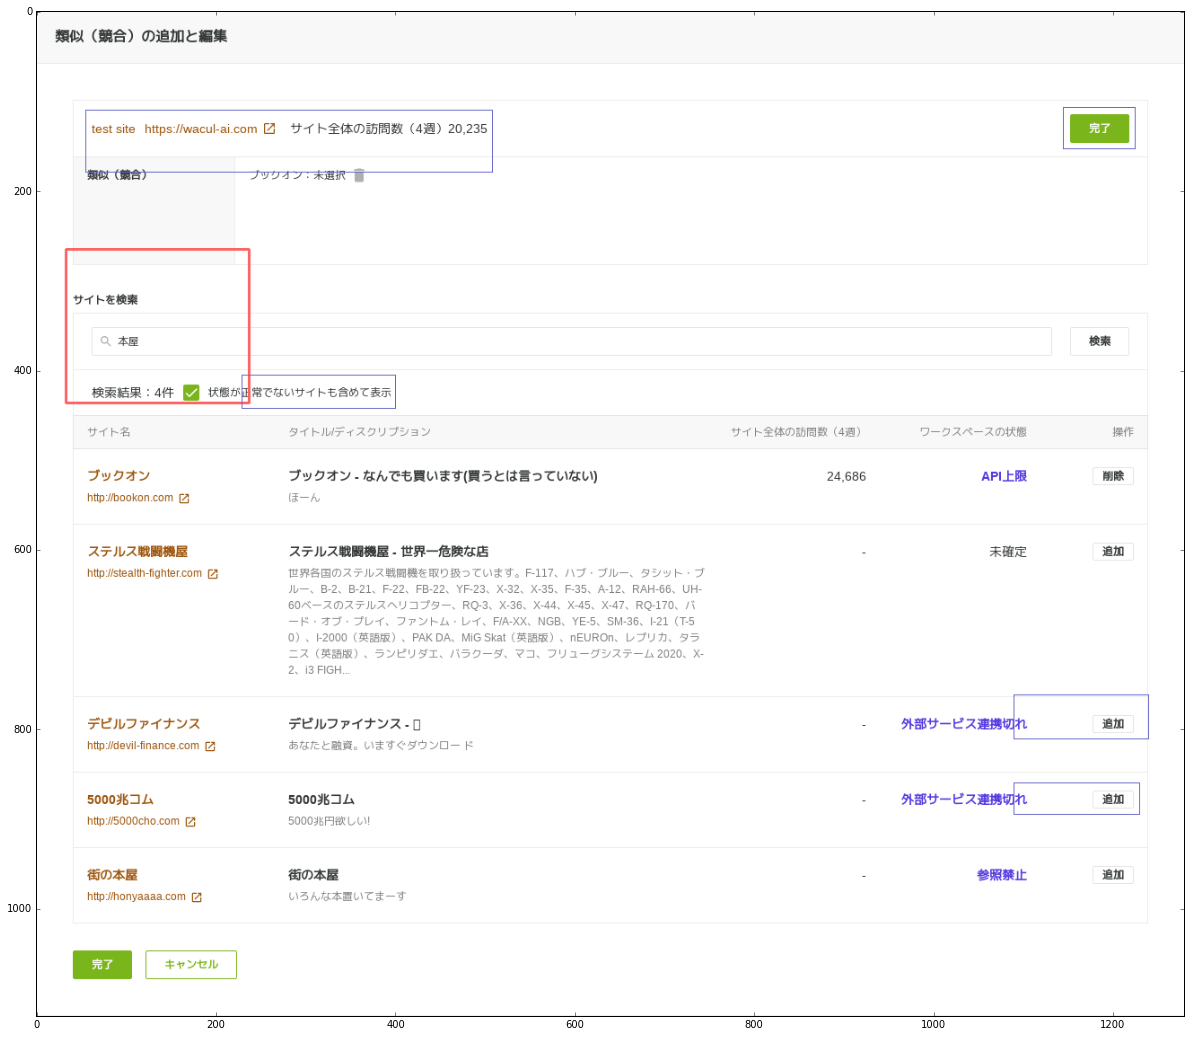

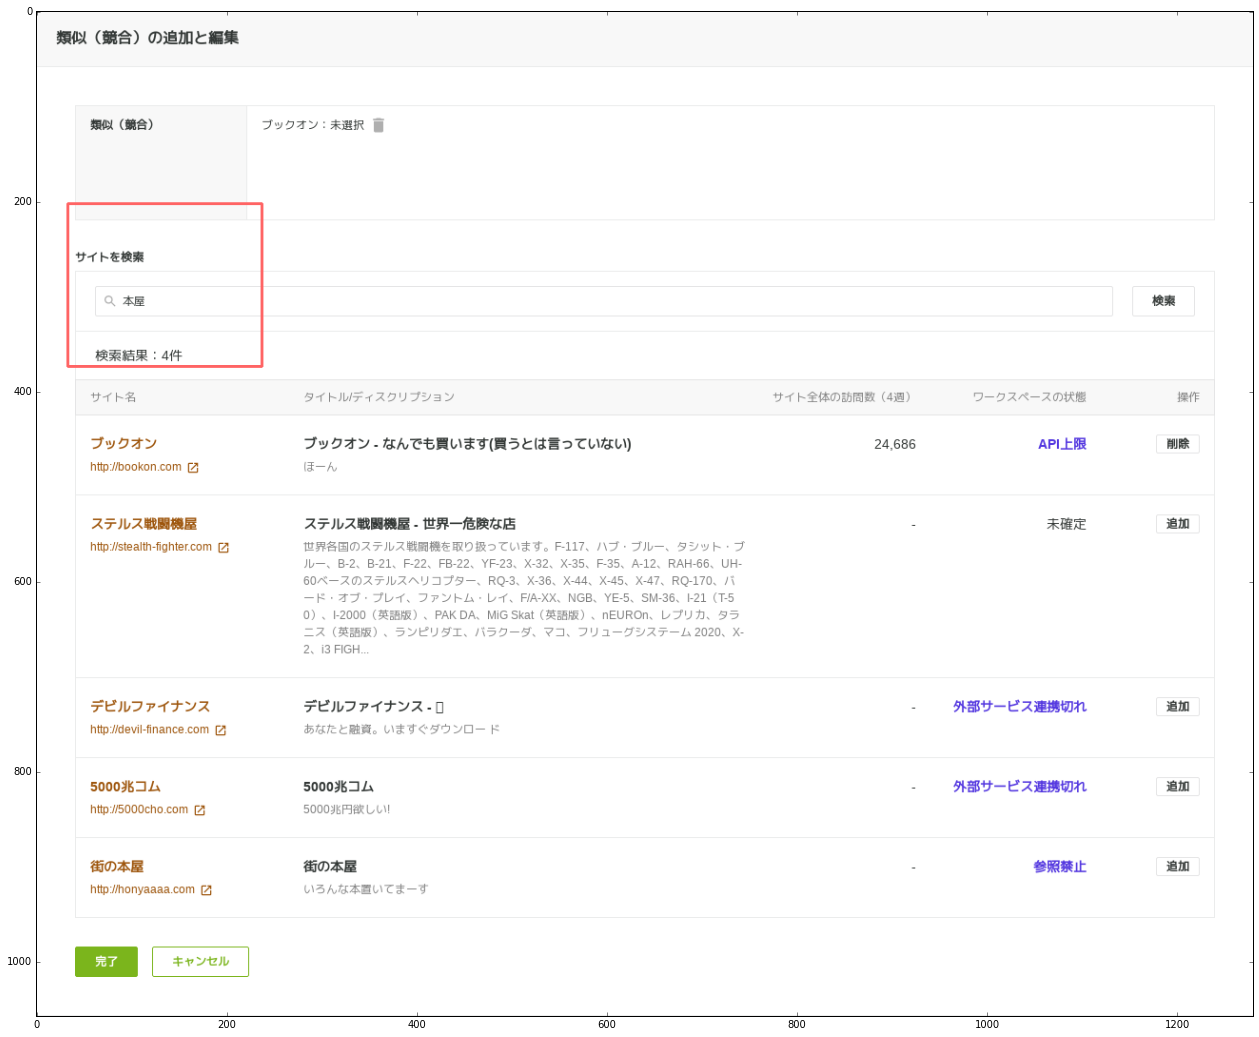

In [11]:
detect_diff('unittest/tuner-similar-ws-components/SimilarSiteAddModalComponent ga check should change valid message to dailyLimitExceeded message if the fetch status is dailyLimitExceeded.png')

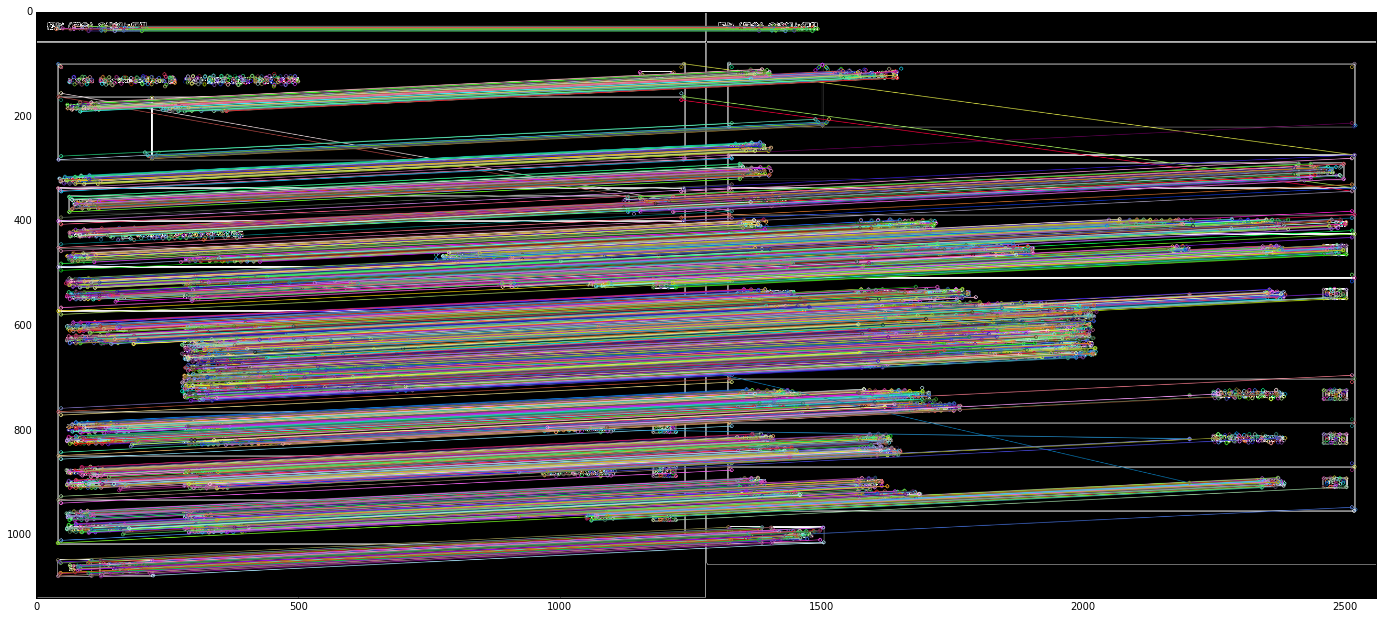

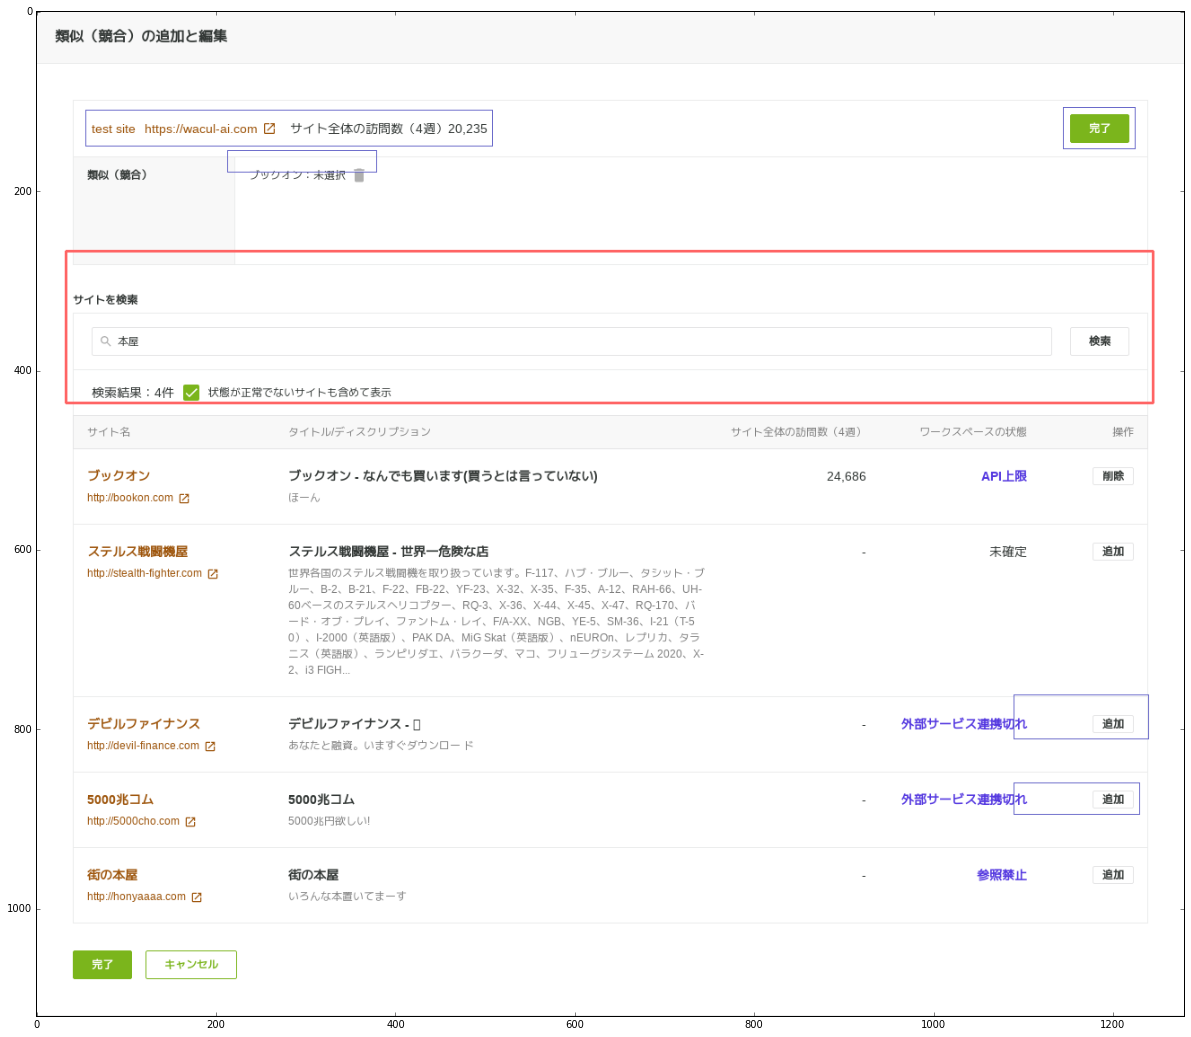

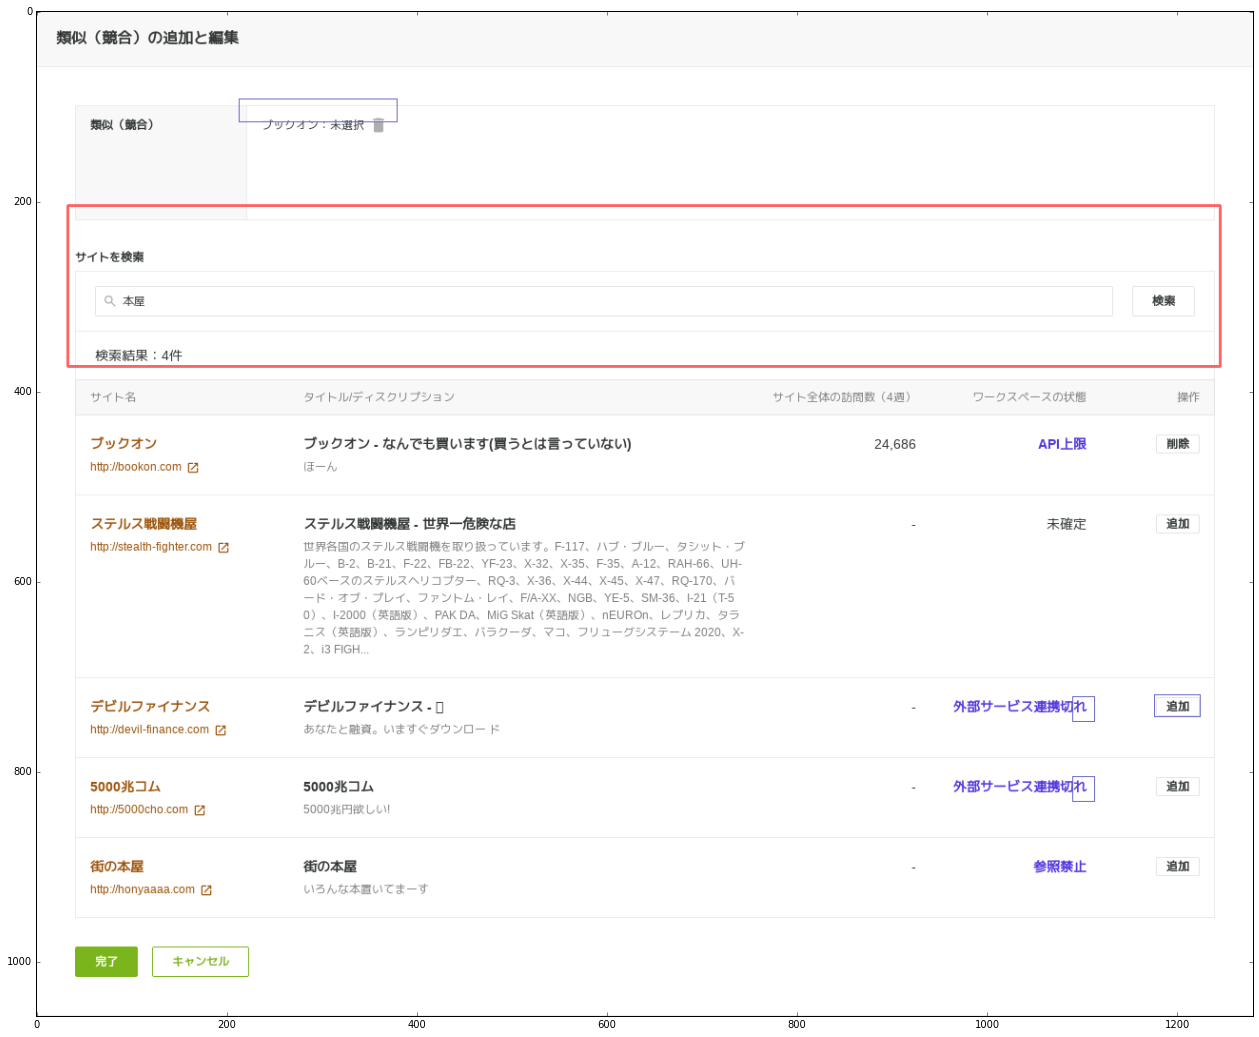

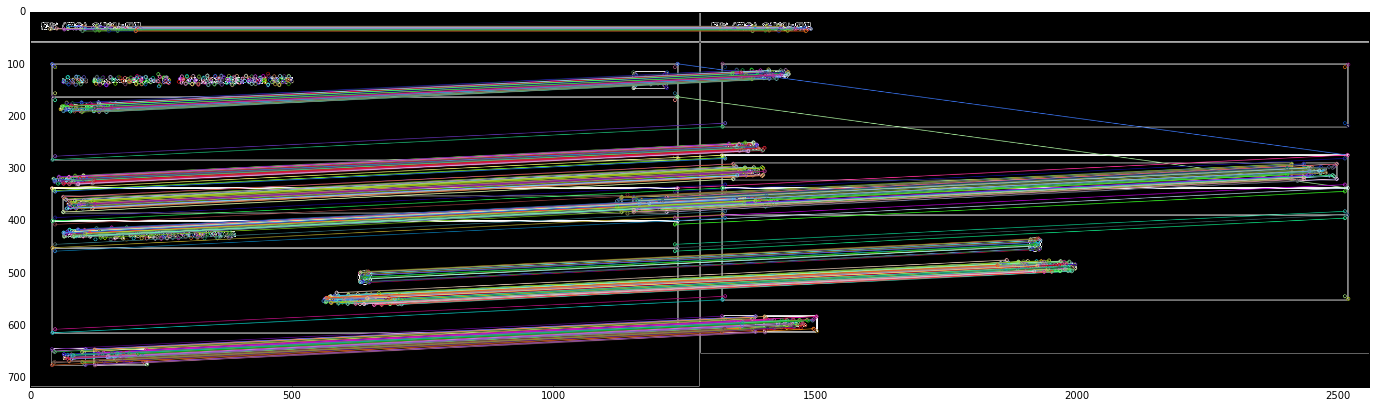

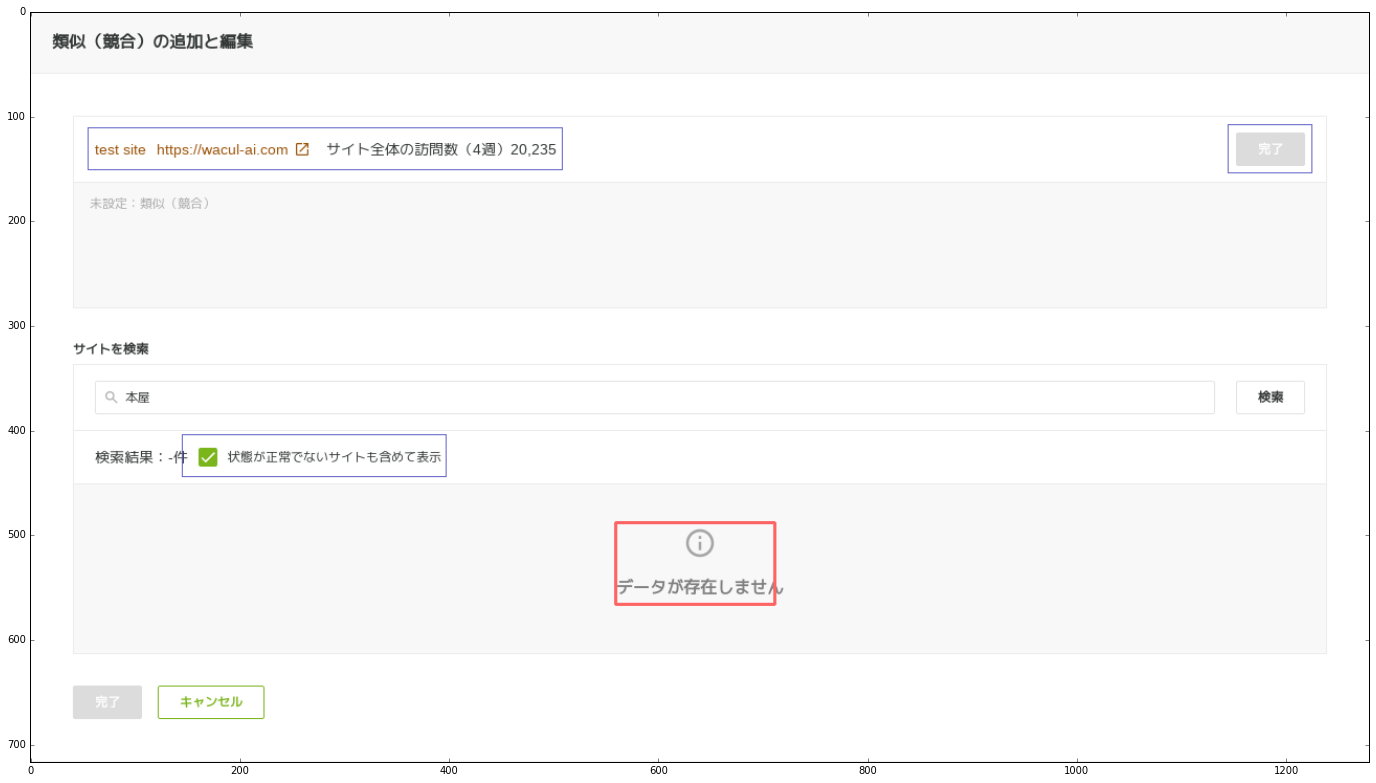

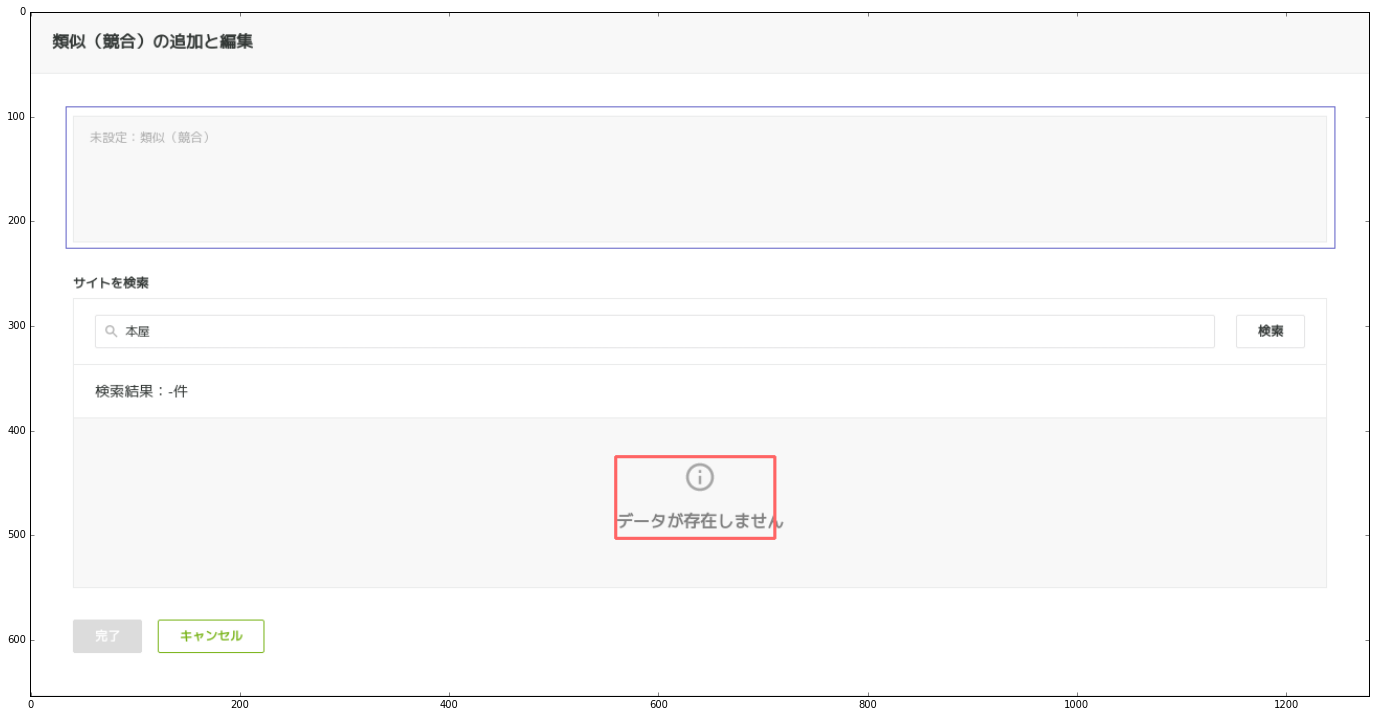

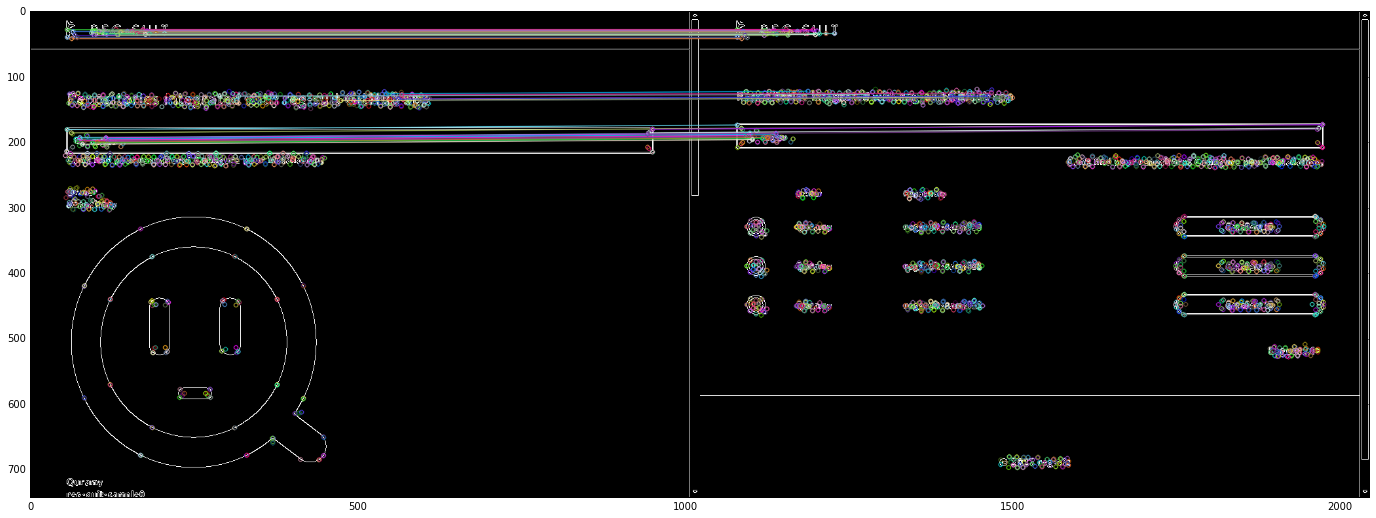

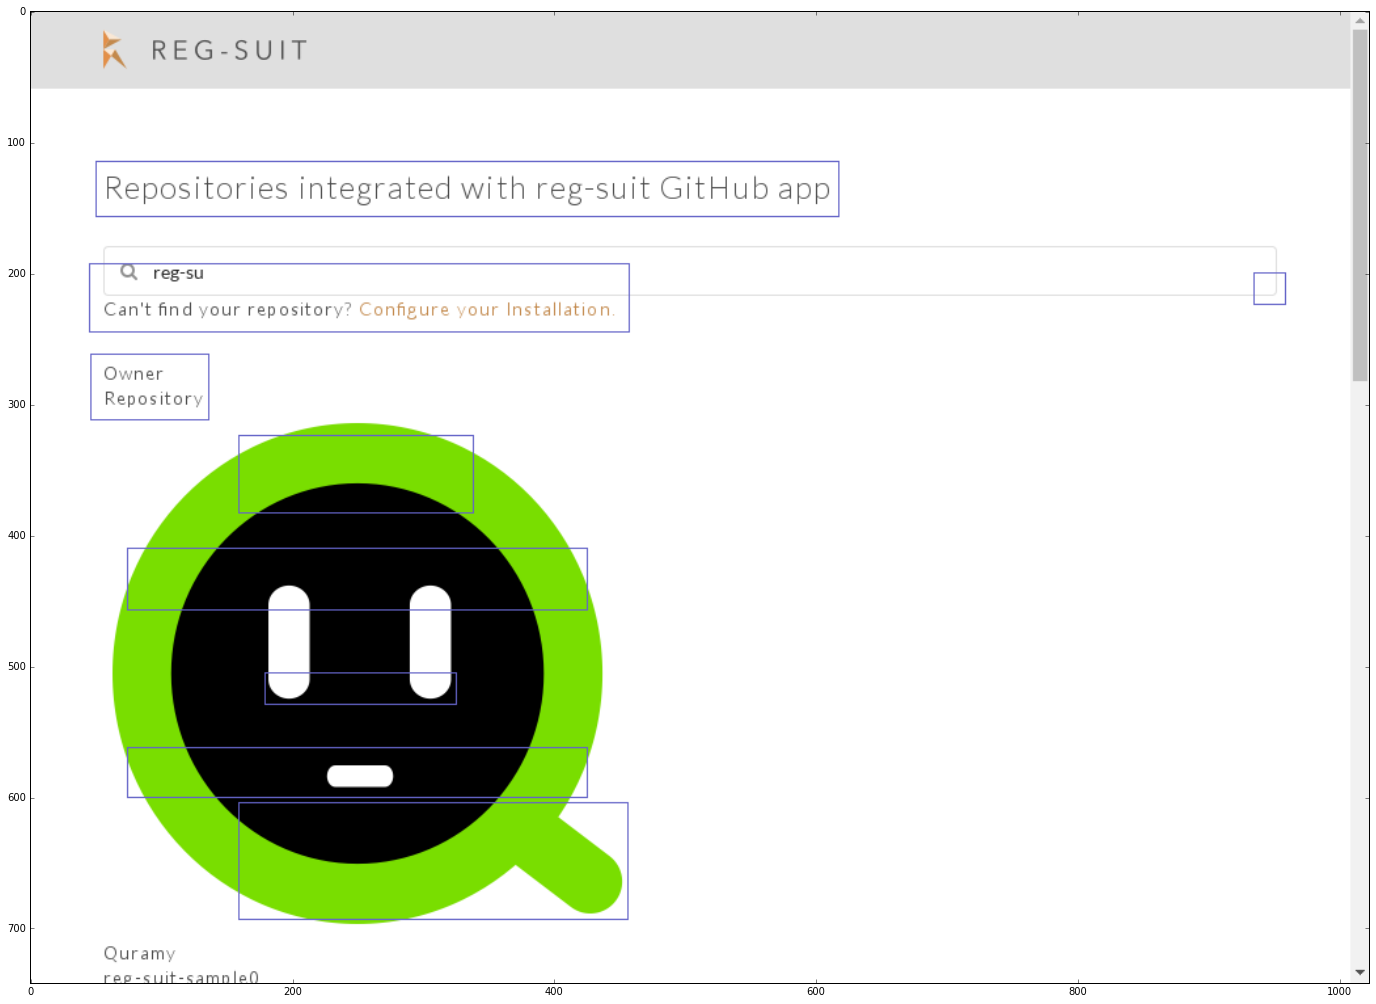

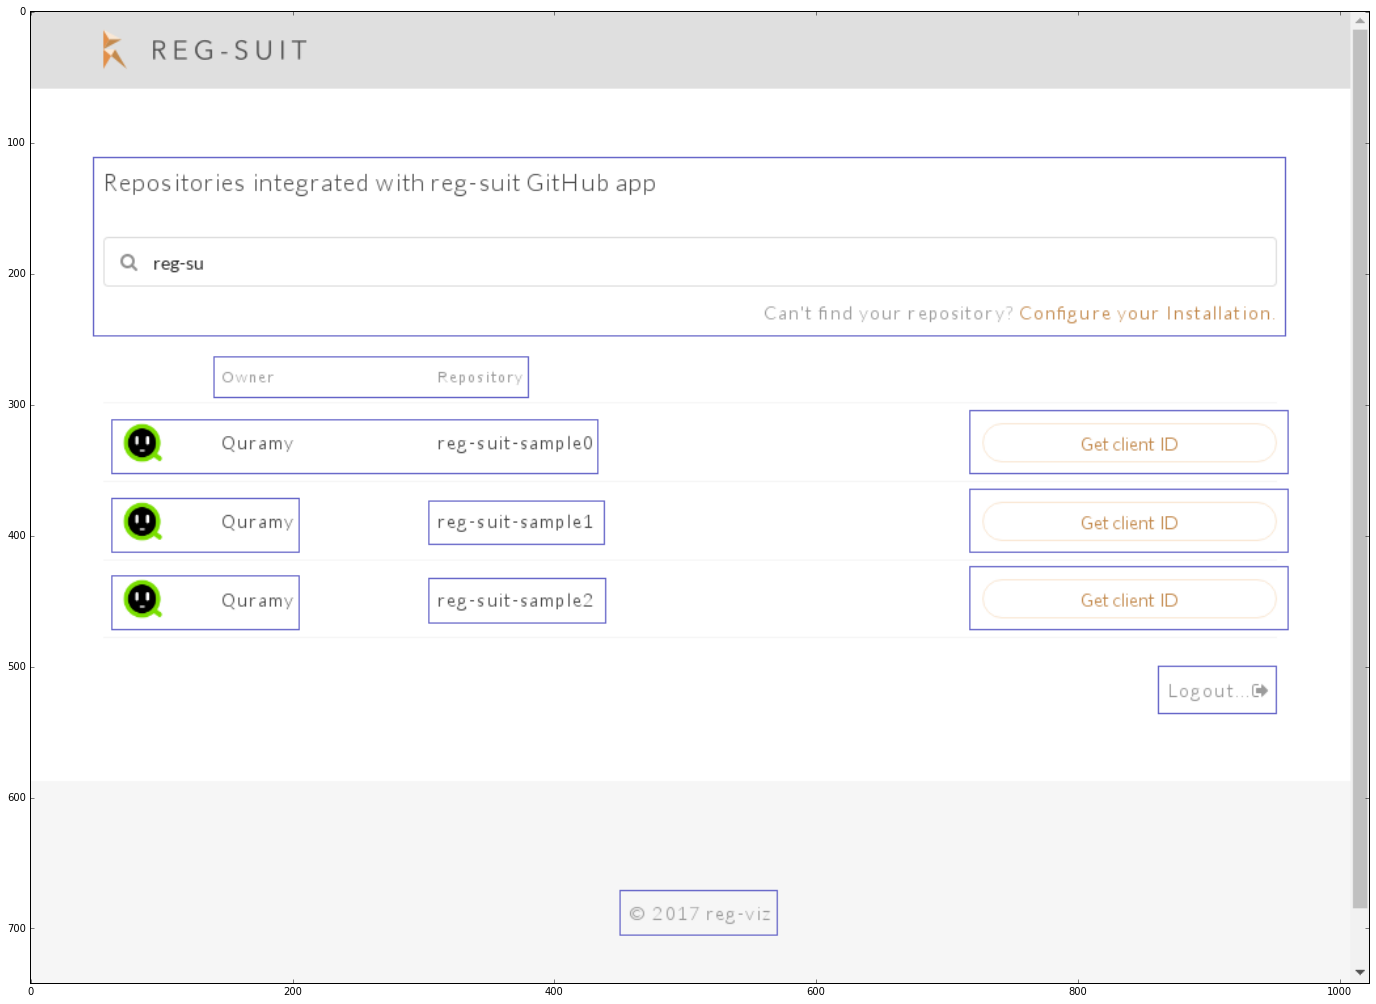

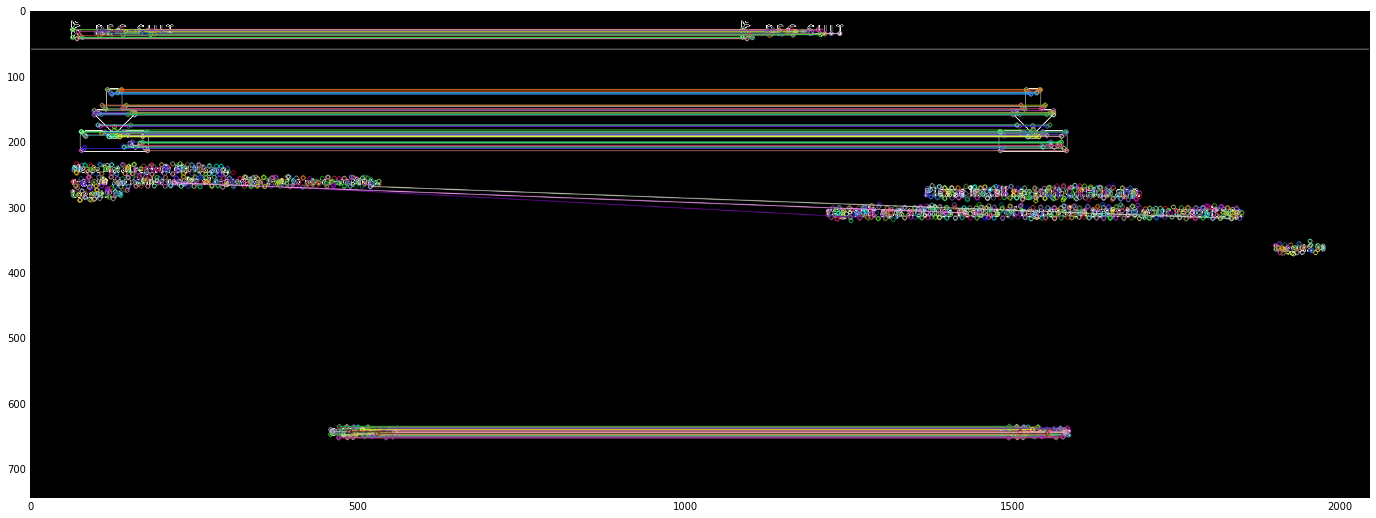

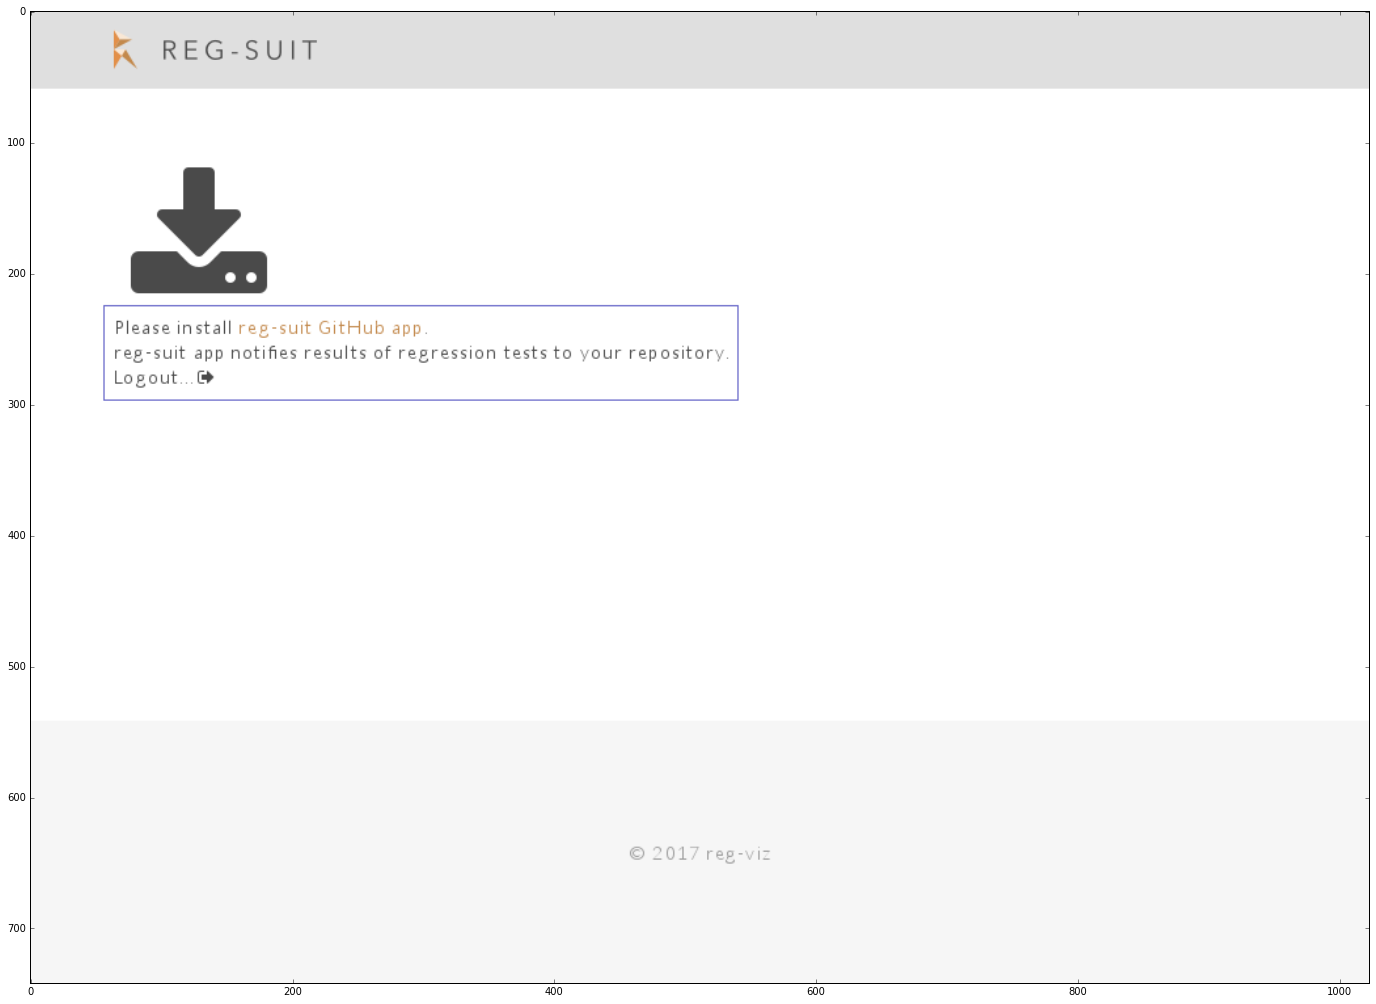

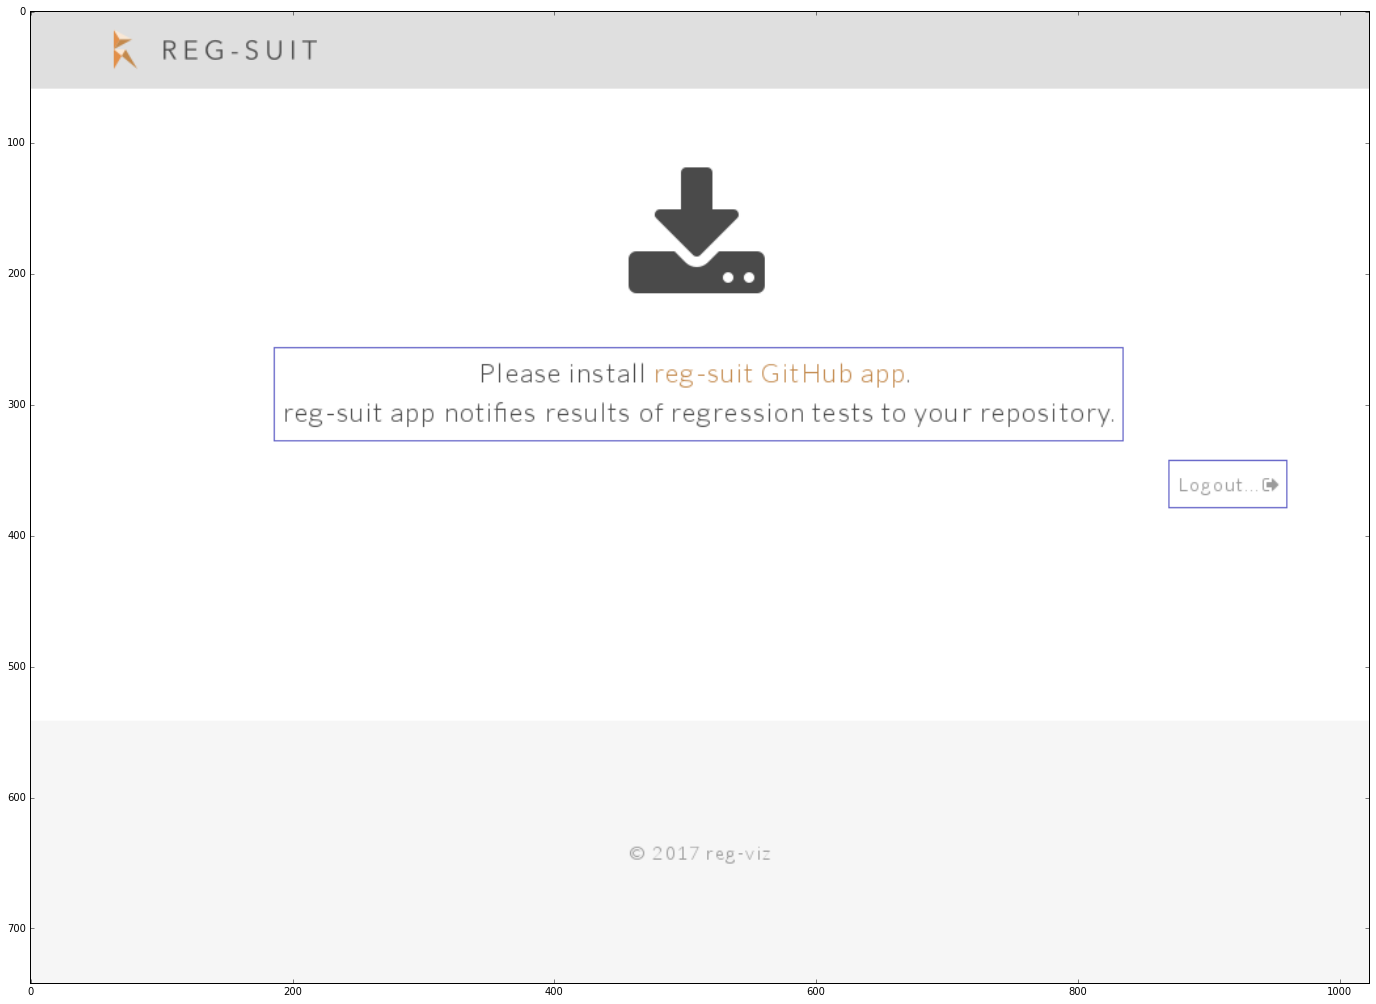

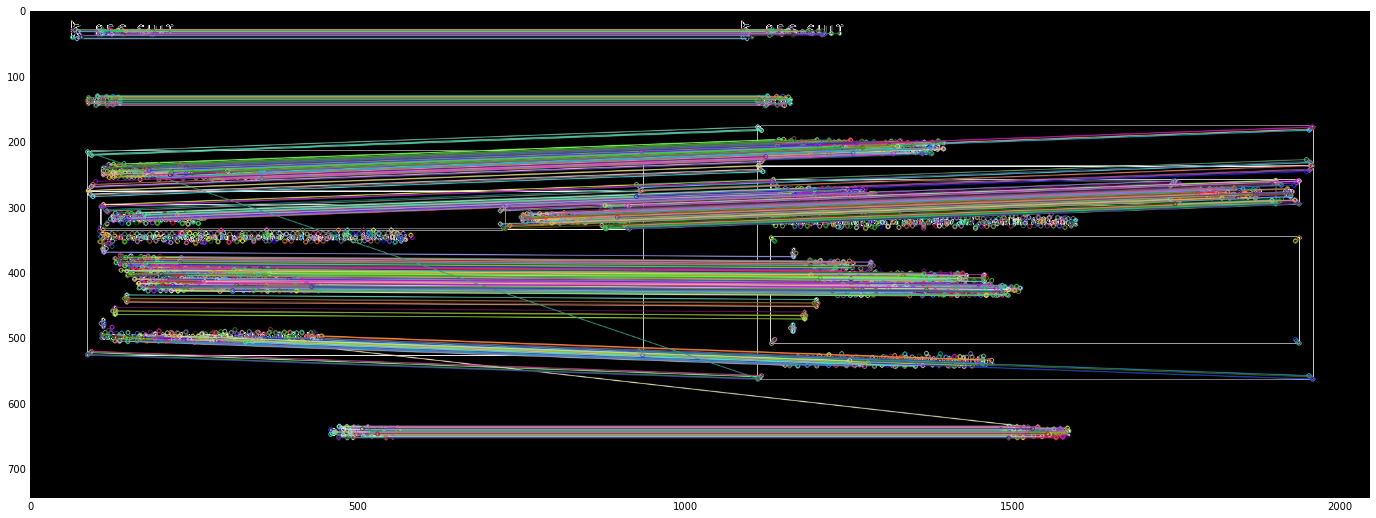

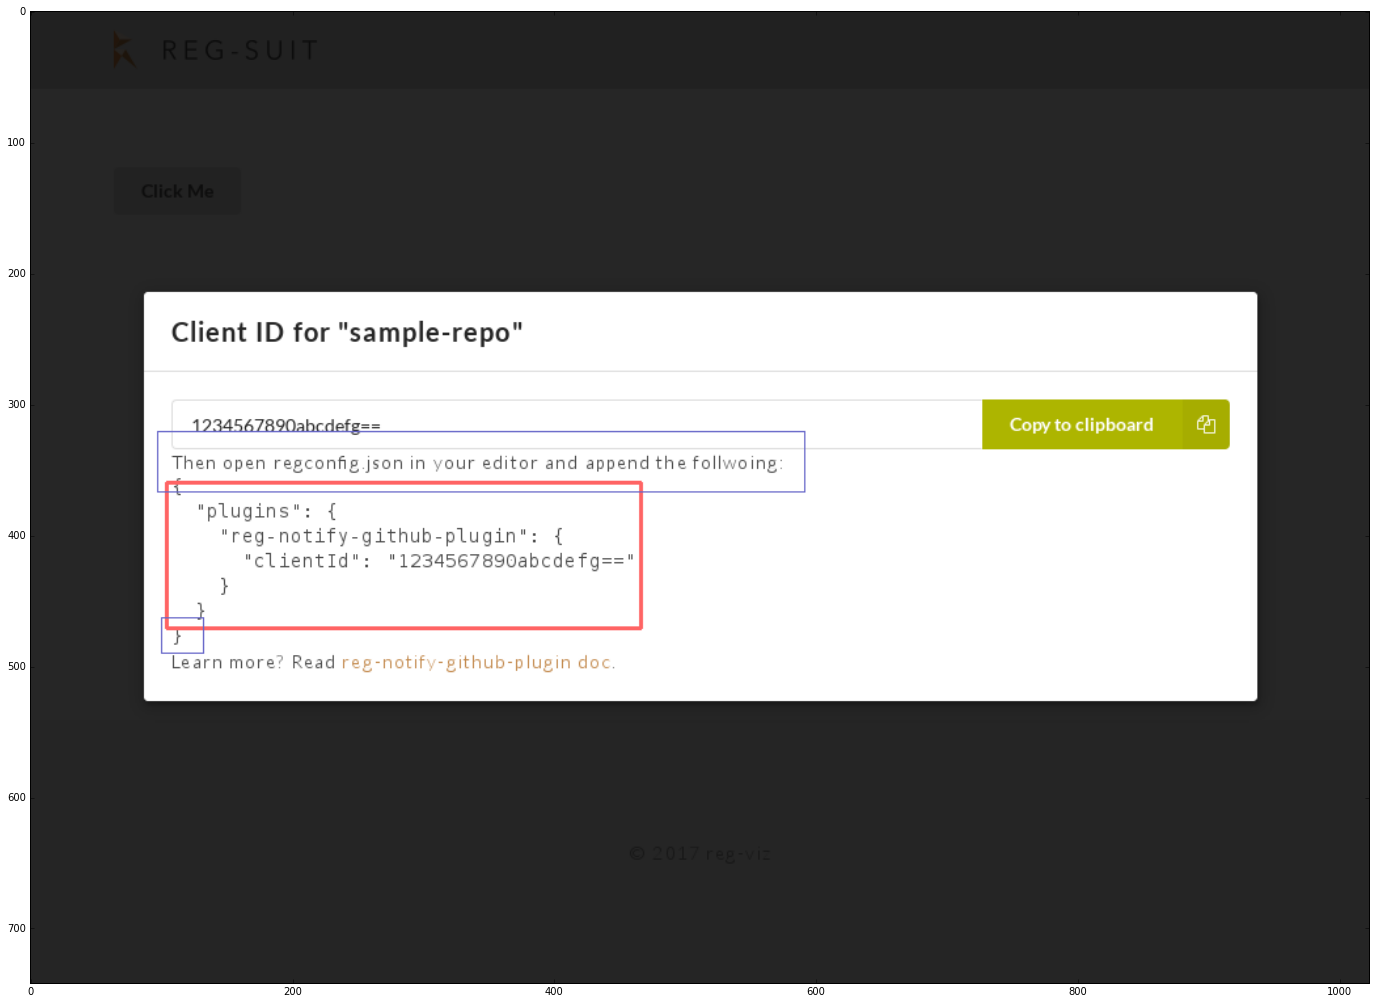

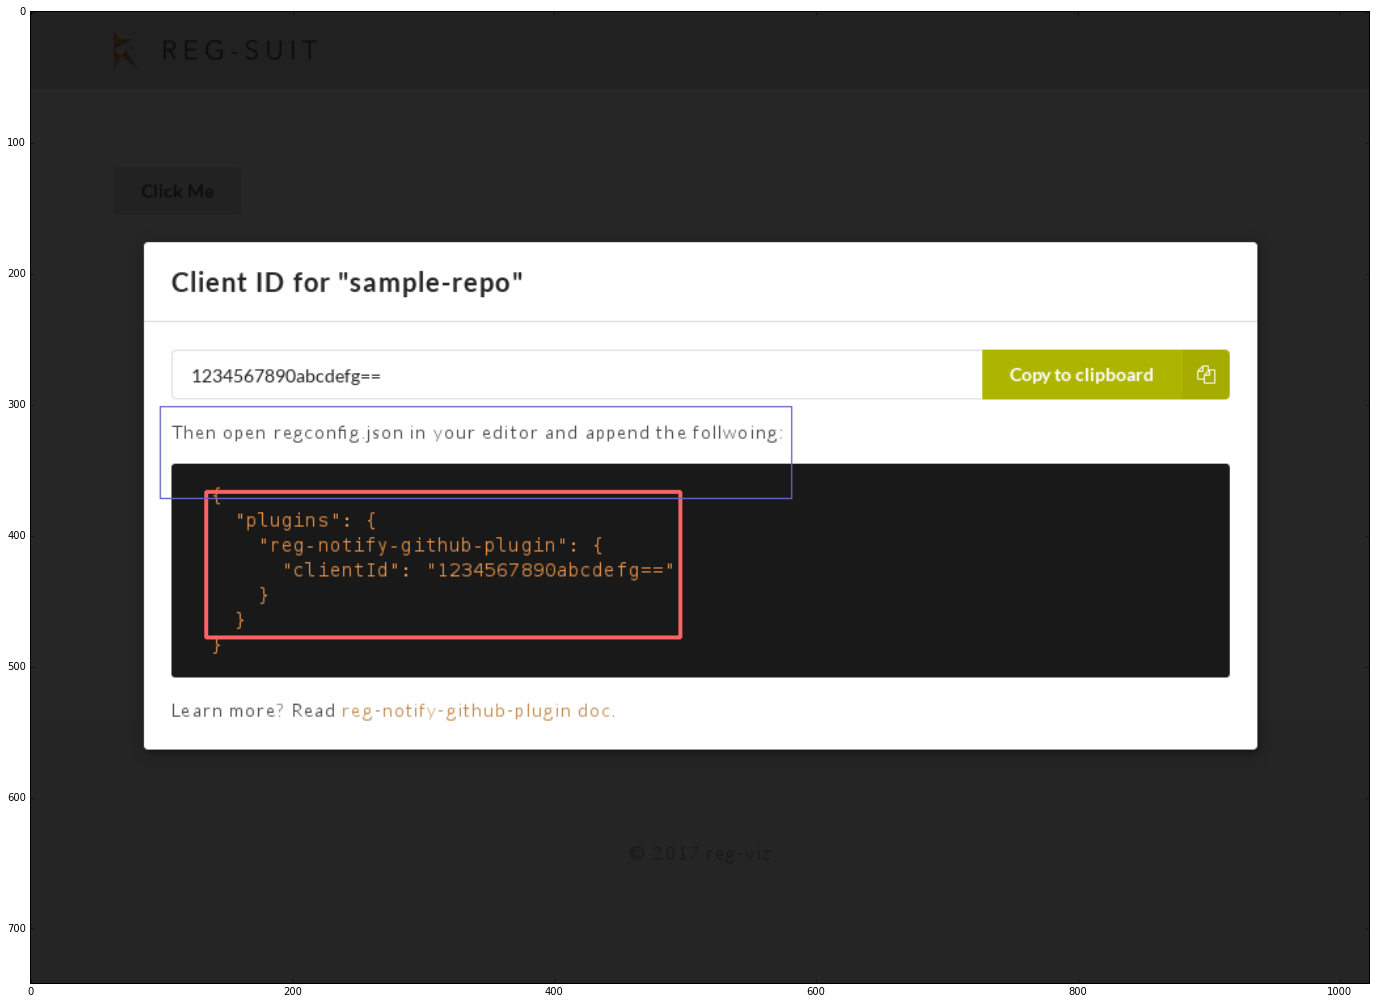

In [9]:
suffix_list = [
    'unittest/tuner-similar-ws-components/SimilarSiteAddModalComponent ga check should change valid message to dailyLimitExceeded message if the fetch status is dailyLimitExceeded.png',
    'unittest/tuner-similar-ws-components/SimilarSiteAddModalComponent should debounce to fetch similar sites.png',
    'gh-app-front/app_installations.png',
    'gh-app-front/app_goto_install.png',
    'gh-app-front/client-id-modal.png'
]

for suffix in suffix_list:
    detect_diff(suffix)